<a href="https://colab.research.google.com/github/rahil1303/dmt-assignment1-2025/blob/main/notebooks/02_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Step 1: Clone the repo
#!git clone https://github.com/rahil1303/dmt-assignment1-2025.git

# Step 2: Change directory to your repo
#%cd dmt-assignment1-2025

# Step 3: Install dependencies (optional)
#!pip install -r requirements.txt
import os
os.chdir('..')
os.getcwd()


'/home/ivanka/data-mining/dmt-assignment1-2025'

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_data_validation as tfdv


In [15]:
pd.set_option("display.max_rows", None)

In [62]:
df = pd.read_csv('cleaned_data.csv')
df_old = pd.read_excel('data/ODI-2025.xlsx')
print(f"New: {df.columns}\n Old: {df_old.columns}")

New: Index(['TIMESTAMP', 'PROGRAM', 'ML_COURSE_NUM', 'IR_COURSE_NUM',
       'DB_COURSE_NUM', 'CHATGPT_USAGE_NUM', 'GENDER_CATEGORIZED',
       'ROOM_ESTIMATE_CLEANED', 'STRESS_LEVEL_CLEANED', 'SPORTS_HOURS_CLEANED',
       'RANDOM_NUMBER_CLEANED', 'AGE', 'BIRTHDAY_MONTH', 'BIRTHDAY_DAY',
       'BEDTIME_CLEANED', 'GOOD_DAY_1_CLEAN', 'GOOD_DAY_2_CLEAN',
       'GOOD_DAY_CLEANED_1'],
      dtype='object')
 Old: Index(['Tijdstempel', 'What programme are you in?',
       'Have you taken a course on machine learning?',
       'Have you taken a course on information retrieval?',
       'Have you taken a course on statistics?',
       'Have you taken a course on databases?', 'What is your gender?',
       'I have used ChatGPT to help me with some of my study assignments ',
       'When is your birthday (date)?',
       'How many students do you estimate there are in the room?',
       'What is your stress level (0-100)?',
       'How many hours per week do you do sports (in whole hours)? ',


In [63]:
df["STRESS_LEVEL_CLEANED"].isna().sum()

0

In [167]:
# Bin stress into low/medium/high
df['stress_bin'] = pd.cut(df['STRESS_LEVEL_CLEANED'],
                          bins=[-1, 33, 66, 100],
                          labels=['low', 'medium', 'high'])

In [65]:
df['stress_bin'].value_counts()

stress_bin
low       98
medium    74
high      73
Name: count, dtype: int64

In [66]:
df["SPORTS_HOURS_CLEANED"].describe()

count    242.000000
mean       5.550000
std        3.796266
min        0.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       23.000000
Name: SPORTS_HOURS_CLEANED, dtype: float64

In [67]:
# Drop rows with NaNs in key columns
df_model = df[['SPORTS_HOURS_CLEANED', 'stress_bin']].dropna()

X = df_model[['SPORTS_HOURS_CLEANED']]
y = df_model['stress_bin']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [68]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [69]:
# Accuracy
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))

# Confusion matrix plot
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=['low', 'medium', 'high'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['low', 'medium', 'high'], yticklabels=['low', 'medium', 'high'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

plot_cm(y_test, y_pred_nb, "Naive Bayes Confusion Matrix")
plot_cm(y_test, y_pred_dt, "Decision Tree Confusion Matrix")


Naive Bayes Accuracy: 0.3835616438356164
Decision Tree Accuracy: 0.3835616438356164


In [71]:
# tfdv stats for the training set
train_stats = tfdv.generate_statistics_from_dataframe(X_train)
tfdv.visualize_statistics(train_stats)

In [72]:
# tfdv stats for the test set
test_stats = tfdv.generate_statistics_from_dataframe(X_test)
tfdv.visualize_statistics(test_stats)

In [75]:
# Generate schema from training stats
schema = tfdv.infer_schema(train_stats)

# Validate the test statistics using the schema
anomalies = tfdv.validate_statistics(test_stats, schema)

# Display anomalies if there are any
tfdv.display_anomalies(anomalies)

In [76]:
from sklearn.metrics import classification_report

# Naive Bayes
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

# Decision Tree
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

Naive Bayes Classification Report:
              precision    recall  f1-score   support

        high       0.32      0.33      0.32        18
         low       0.59      0.39      0.47        33
      medium       0.28      0.41      0.33        22

    accuracy                           0.38        73
   macro avg       0.40      0.38      0.38        73
weighted avg       0.43      0.38      0.39        73

Decision Tree Classification Report:
              precision    recall  f1-score   support

        high       0.29      0.33      0.31        18
         low       0.55      0.52      0.53        33
      medium       0.24      0.23      0.23        22

    accuracy                           0.38        73
   macro avg       0.36      0.36      0.36        73
weighted avg       0.39      0.38      0.39        73



## DECISION TREE

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters found: ", grid_search.best_params_)

# Use the best model found by GridSearchCV
best_dt = grid_search.best_estimator_

# Make predictions with the best model
y_pred_dt_best = best_dt.predict(X_test)

# Evaluate the performance of the best model
from sklearn.metrics import classification_report
print("Best Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt_best))


Best hyperparameters found:  {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Decision Tree Classification Report:
              precision    recall  f1-score   support

        high       0.29      0.33      0.31        18
         low       0.55      0.52      0.53        33
      medium       0.24      0.23      0.23        22

    accuracy                           0.38        73
   macro avg       0.36      0.36      0.36        73
weighted avg       0.39      0.38      0.39        73



In [79]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print(f"Class distribution after SMOTE: {Counter(y_res)}")

# Train a Decision Tree on the resampled dataset
dt_res = DecisionTreeClassifier(random_state=42)
dt_res.fit(X_res, y_res)

# Make predictions with the resampled dataset
y_pred_dt_res = dt_res.predict(X_test)

# Evaluate the performance of the resampled model
print("Decision Tree with SMOTE Classification Report:")
print(classification_report(y_test, y_pred_dt_res))


Class distribution after SMOTE: Counter({'low': 64, 'medium': 64, 'high': 64})
Decision Tree with SMOTE Classification Report:
              precision    recall  f1-score   support

        high       0.29      0.33      0.31        18
         low       0.59      0.48      0.53        33
      medium       0.32      0.36      0.34        22

    accuracy                           0.41        73
   macro avg       0.40      0.39      0.39        73
weighted avg       0.43      0.41      0.42        73



# CLASSIFICATION FULL CODE

In [98]:
# Required Libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter

# 1. Select Features and Target
features = ['SPORTS_HOURS_CLEANED', 'chatgpt', 'ml_background', 'bedtime_hour']
df_model = df[features + ['stress_bin']].dropna()

X = df_model[features]
y = df_model['stress_bin']

# 2. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Apply SMOTE to Training Data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", Counter(y_train_res))

# 4. Define Hyperparameter Grid for Random Forest
param_grid = {
    'n_estimators': [100],  # You can expand if you want
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'max_features': ['sqrt']
}

# 5. Initialize and Tune Model
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

# 6. Evaluate Best Model
best_rf = grid_search.best_estimator_
print("Best RF params:", grid_search.best_params_)

y_pred = best_rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))


Class distribution after SMOTE: Counter({'low': 64, 'medium': 64, 'high': 64})
Best RF params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Classification Report:
              precision    recall  f1-score   support

        high       0.40      0.44      0.42        18
         low       0.52      0.45      0.48        33
      medium       0.33      0.36      0.35        22

    accuracy                           0.42        73
   macro avg       0.42      0.42      0.42        73
weighted avg       0.43      0.42      0.43        73



## CHOOSING FEATURES

In [99]:
df.columns

Index(['TIMESTAMP', 'PROGRAM', 'ML_COURSE_NUM', 'IR_COURSE_NUM',
       'DB_COURSE_NUM', 'CHATGPT_USAGE_NUM', 'GENDER_CATEGORIZED',
       'ROOM_ESTIMATE_CLEANED', 'STRESS_LEVEL_CLEANED', 'SPORTS_HOURS_CLEANED',
       'RANDOM_NUMBER_CLEANED', 'AGE', 'BIRTHDAY_MONTH', 'BIRTHDAY_DAY',
       'BEDTIME_CLEANED', 'GOOD_DAY_1_CLEAN', 'GOOD_DAY_2_CLEAN',
       'GOOD_DAY_CLEANED_1', 'stress_bin', 'chatgpt', 'ml_background',
       'bedtime_hour'],
      dtype='object')

In [107]:
from sklearn.preprocessing import LabelEncoder
# Initialize label encoder
label_encoder = LabelEncoder()
# Apply label encoding to gender
df['gender'] = label_encoder.fit_transform(df['GENDER_CATEGORIZED'])

In [115]:
# Encode the 'PROGRAM' column
df['program'] = label_encoder.fit_transform(df['PROGRAM'])

In [128]:
import numpy as np

# Check the distribution of BIRTHDAY_MONTH
print(df['BIRTHDAY_MONTH'].describe())

# Apply sine and cosine transformations for the 'BIRTHDAY_MONTH'
df['BIRTHDAY_MONTH_sin'] = np.sin(2 * np.pi * df['BIRTHDAY_MONTH'] / 12)
df['BIRTHDAY_MONTH_cos'] = np.cos(2 * np.pi * df['BIRTHDAY_MONTH'] / 12)

# Impute missing values in sine and cosine columns with the mean
df['BIRTHDAY_MONTH_sin'] = df['BIRTHDAY_MONTH_sin'].fillna(df['BIRTHDAY_MONTH_sin'].mean())
df['BIRTHDAY_MONTH_cos'] = df['BIRTHDAY_MONTH_cos'].fillna(df['BIRTHDAY_MONTH_cos'].mean())


count    227.000000
mean       6.224670
std        3.742569
min        1.000000
25%        3.000000
50%        6.000000
75%       10.000000
max       12.000000
Name: BIRTHDAY_MONTH, dtype: float64


NUMERICAL: 'GENDER_CATEGORIZED'-> 'gender' (0,1,2,3,4), 'ML_COURSE_NUM' -> 'ml_background' (1 and 0),'CHATGPT_USAGE_NUM'-> 'chatgpt'(1 and 0),'ROOM_ESTIMATE_CLEANED' (continuous), 'SPORTS_HOURS_CLEANED'(continuous), 'RANDOM_NUMBER_CLEANED'(student's random numbers), 'BIRTHDAY_MONTH' -> 'BIRTHDAY_MONTH_sin' and 'BIRTHDAY_MONTH_cos', 'BEDTIME_CLEANED'->'bedtime_hour'(integers), 'PROGRAM'->'program' (integers)

TARGET: 'STRESS_LEVEL_CLEANED' -> 'stress_bin'(when prepared for the model-high, low, medium)

## MODEL - RANDOM FOREST

In [150]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare the features and target
features = ['ROOM_ESTIMATE_CLEANED', 
            'SPORTS_HOURS_CLEANED', 
            'BIRTHDAY_MONTH_sin', 'BIRTHDAY_MONTH_cos', 'bedtime_hour']


X = df[features]
y = df['stress_bin']

# Drop rows with missing values in features or target
df_clean = df.dropna(subset=features + ['stress_bin'])
X_clean = df_clean[features]
y_clean = df_clean['stress_bin']

# Split the cleaned data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42)

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        high       0.42      0.53      0.47        19
         low       0.47      0.64      0.55        28
      medium       0.30      0.12      0.17        25

    accuracy                           0.43        72
   macro avg       0.40      0.43      0.39        72
weighted avg       0.40      0.43      0.39        72



In [151]:
import pandas as pd

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to view the features and their importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(importance_df)


                 Feature  Importance
0  ROOM_ESTIMATE_CLEANED    0.289113
1   SPORTS_HOURS_CLEANED    0.255606
4           bedtime_hour    0.178132
3     BIRTHDAY_MONTH_cos    0.142045
2     BIRTHDAY_MONTH_sin    0.135104


In [152]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

# Evaluate the model with the best parameters
best_rf = grid_search.best_estimator_

# Make predictions
y_pred = best_rf.predict(X_test)

# Evaluate the model
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estim

/home/ivanka/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
458 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ivanka/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ivanka/.local/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/ivanka/.local/lib/python3.10/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/home/ivanka/.

Best Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-validation Score: 0.4213903743315508
              precision    recall  f1-score   support

        high       0.42      0.58      0.49        19
         low       0.50      0.71      0.59        28
      medium       0.33      0.08      0.13        25

    accuracy                           0.46        72
   macro avg       0.42      0.46      0.40        72
weighted avg       0.42      0.46      0.40        72



BEST MODEL SO FAR

In [153]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare the features and target
features = ['ROOM_ESTIMATE_CLEANED', 
            'SPORTS_HOURS_CLEANED', 
            'BIRTHDAY_MONTH_sin', 'BIRTHDAY_MONTH_cos', 'bedtime_hour']

X = df[features]
y = df['stress_bin']

# Drop rows with missing values in features or target
df_clean = df.dropna(subset=features + ['stress_bin'])
X_clean = df_clean[features]
y_clean = df_clean['stress_bin']

# Split the cleaned data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42)

# Initialize the Random Forest classifier with the best parameters
rf = RandomForestClassifier(
    bootstrap=True, 
    max_depth=None, 
    max_features='sqrt', 
    min_samples_leaf=2, 
    min_samples_split=10, 
    n_estimators=200,
    random_state=42
)

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        high       0.42      0.58      0.49        19
         low       0.50      0.71      0.59        28
      medium       0.33      0.08      0.13        25

    accuracy                           0.46        72
   macro avg       0.42      0.46      0.40        72
weighted avg       0.42      0.46      0.40        72



# WINNING MODEL  - RANDOM FOREST

In [155]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare the features and target
features = ['ROOM_ESTIMATE_CLEANED', 
            'SPORTS_HOURS_CLEANED', 
            'BIRTHDAY_MONTH_sin', 'BIRTHDAY_MONTH_cos', 'bedtime_hour']

X = df[features]
y = df['stress_bin']

# Drop rows with missing values in features or target
df_clean = df.dropna(subset=features + ['stress_bin'])
X_clean = df_clean[features]
y_clean = df_clean['stress_bin']

# Split the cleaned data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42)

# Initialize the Random Forest classifier with class weight adjustment
rf = RandomForestClassifier(
    bootstrap=True, 
    max_depth=None, 
    max_features='sqrt', 
    min_samples_leaf=2, 
    min_samples_split=10, 
    n_estimators=200,
    class_weight='balanced',  # Handling class imbalance
    random_state=42
)

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        high       0.43      0.63      0.51        19
         low       0.52      0.57      0.54        28
      medium       0.46      0.24      0.32        25

    accuracy                           0.47        72
   macro avg       0.47      0.48      0.46        72
weighted avg       0.47      0.47      0.46        72



## OLD

In [81]:
df["CHATGPT_USAGE_NUM"].unique()

array([ 1., nan,  0.])

In [82]:
# Map 1.0 → 1, 0.0 → 0, and optionally NaN → 1 (or something else)
df['chatgpt'] = df['CHATGPT_USAGE_NUM'].map({
    1.0: 1,
    0.0: 0
})

# Treat NaN as 1
df['chatgpt'] = df['chatgpt'].fillna(1)

# Convert to Int
df['chatgpt'] = df['chatgpt'].astype(int)

# Display
df['chatgpt'].unique()

array([1, 0])

In [83]:
# 2. ML Background → Binary
df['ml_background'] = df['ML_COURSE_NUM']

In [84]:
# 3. Bedtime → Convert HH:MM to hour (numeric)
df['bedtime_hour'] = pd.to_datetime(df["BEDTIME_CLEANED"], errors='coerce').dt.hour

/tmp/ipykernel_538936/986077588.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['bedtime_hour'] = pd.to_datetime(df["BEDTIME_CLEANED"], errors='coerce').dt.hour


In [85]:
features = ['SPORTS_HOURS_CLEANED', 'chatgpt', 'ml_background', 'bedtime_hour']
df_expanded = df[features + ['stress_bin']].dropna()

X = df_expanded[features]
y = df_expanded['stress_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [86]:
# Naive Bayes
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

# Decision Tree
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)


Naive Bayes Accuracy (Expanded): 0.3835616438356164
Decision Tree Accuracy (Expanded): 0.3972602739726027


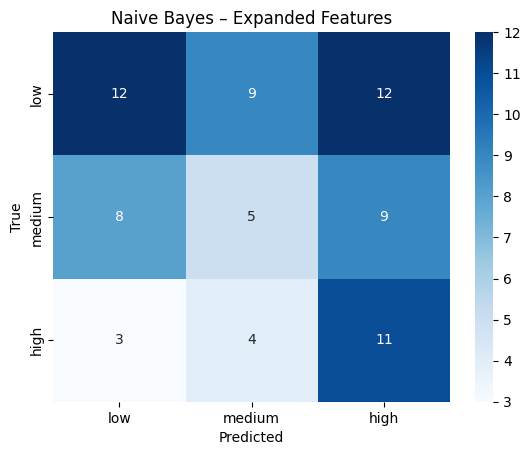

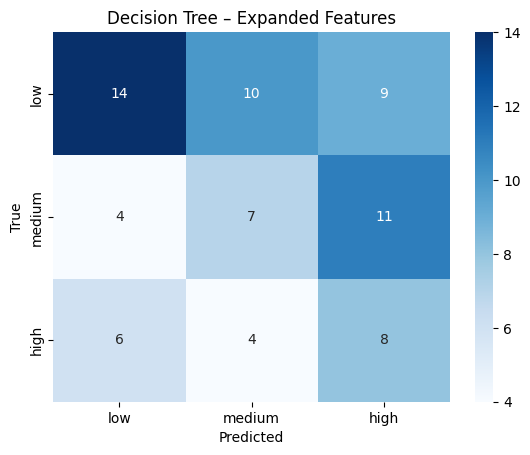

In [87]:
print("Naive Bayes Accuracy (Expanded):", accuracy_score(y_test, y_pred_nb))
print("Decision Tree Accuracy (Expanded):", accuracy_score(y_test, y_pred_dt))

plot_cm(y_test, y_pred_nb, "Naive Bayes – Expanded Features")
plot_cm(y_test, y_pred_dt, "Decision Tree – Expanded Features")


In [91]:
from sklearn.naive_bayes import GaussianNB

# 1. Train Naive Bayes on SMOTE-resampled data
nb = GaussianNB()
nb.fit(X_train_resampled, y_train_resampled)

# 2. Predict on the *original* test set
y_pred_nb = nb.predict(X_test)

# 3. Evaluate
print("Naive Bayes with SMOTE Classification Report:")
print(classification_report(y_test, y_pred_nb))

Naive Bayes with SMOTE Classification Report:
              precision    recall  f1-score   support

        high       0.38      0.50      0.43        18
         low       0.62      0.24      0.35        33
      medium       0.31      0.50      0.38        22

    accuracy                           0.38        73
   macro avg       0.43      0.41      0.39        73
weighted avg       0.46      0.38      0.38        73



RANDOM FOREST DEEPER

In [93]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

print("Best RF params:", grid_search_rf.best_params_)
best_rf = grid_search_rf.best_estimator_
print(classification_report(y_test, best_rf.predict(X_test)))


/home/ivanka/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
171 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ivanka/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ivanka/.local/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/ivanka/.local/lib/python3.10/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/home/ivanka/.lo

Best RF params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

        high       0.40      0.44      0.42        18
         low       0.52      0.45      0.48        33
      medium       0.33      0.36      0.35        22

    accuracy                           0.42        73
   macro avg       0.42      0.42      0.42        73
weighted avg       0.43      0.42      0.43        73



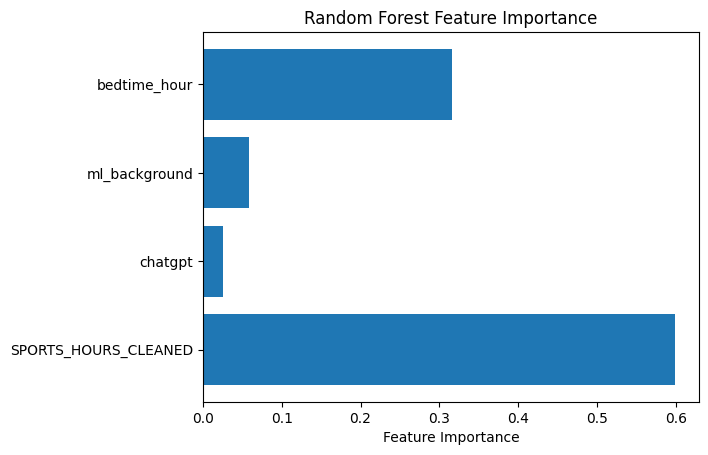

In [94]:
import matplotlib.pyplot as plt

importances = best_rf.feature_importances_
feature_names = X_train.columns
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()


In [97]:
top_features = ['SPORTS_HOURS_CLEANED', 'bedtime_hour']
X_top = df_expanded[top_features]
y = df_expanded['stress_bin']

X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.3, random_state=42)

rf.fit(X_train, y_train)
print(classification_report(y_test, rf.predict(X_test)))


              precision    recall  f1-score   support

        high       0.32      0.39      0.35        18
         low       0.59      0.39      0.47        33
      medium       0.31      0.41      0.35        22

    accuracy                           0.40        73
   macro avg       0.41      0.40      0.39        73
weighted avg       0.44      0.40      0.41        73

